# Sample Code Run for `xagg`
(not yet a package - still in alpha.)

A quick guide to `xagg`, explaining how to use it to aggregate raster data to polygons, with a little bit of info on what goes on under the hood.

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import warnings
import xesmf as xe

## Intro

We'll be aggregating a gridded dataset onto a set of shapefiles, using an extra set of weights. Specifically, we'll use:
- gridded: month-of-year average temperature projections for the end-of-century from a climate model (CCSM4)
- shapefiles: US counties
- additional weights: global gridded population density ([GPW](https://sedac.ciesin.columbia.edu/data/collection/gpw-v4), 15 min resolution)

This is a setup that you may for example use if projecting the impact of temperature on some human variable (temperature vs. mortality, for example) for which you have data at the US county level. Since your mortality data is likely at the county level, you need to aggregate the gridded climate model output data to counties - i.e., what is the average temperature over each county? This code will calculate which pixels overlap each county - and by how much - allowing an area-averaged value for monthly temperature at the county level. 

However, you also care about where people live - so you'd like to additionally weight your temperature estimate by a population density dataset. This code easily allows such additional weights. The resultant output is a value of temperature for each month at each county, averaged by both the overlap of individual pixels and the population density in those pixels. 

Let's get started.

In [2]:
# Load some climate data as an xarray dataset
ds = xr.open_dataset('data/climate_data/tas_Amon_CCSM4_rcp85_monthavg_20700101-20991231.nc')

In [3]:
# Load US counties shapefile as a geopandas GeoDataFrame
gdf = gpd.read_file('data/geo_data/UScounties.shp')

In [4]:
# Load global gridded population data from GPW
ds_pop = xr.open_dataset('data/pop_data/gpw_v4_population_density_rev11_15_min.nc')
# Some edits to make sure it's in the right format (an xarray DataArray)
ds_pop = ds_pop['Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 15 arc-minutes']
ds_pop = ds_pop.isel(raster=0)

Now, let's load `xagg` (at least in its current form as just a `python` script full of all the functions)

In [5]:
import xagg as xa

## Calculating area weights between a raster grid and polygons
First, we have to figure out how much each pixel overlaps each polygon. This process requires a few steps:

0. Get everything in the right format. 
    * Gridded data comes in all shapes and sizes. `xagg` is ready to deal with most common grid naming conventions - so no matter if your lat and lon variables are called 'Latitude' and 'Longitude' or 'y' and 'x' or many options in between, as long as they're in xarray Datasets or DataArrays, they'll work. 
    * Behind the scenes, longitude values are also forced to -180:180 (from 0:360, if applicable), just to make sure everything is operating in the same coordinate system. 
1. Build polygons for each pixel 
    * To figure out how much each pixel overlaps each polygon, pixel polygons have to be constructed. If your gridded variable already has "lat_bnds" and "lon_bnds" (giving the vertices of each pixel) explicitly included in the `xr.Dataset`, then those are used. If none are found, "lat_bnds" and "lon_bnds" are constructed by assuming the vertices are halfway between the coordinates in degrees. 
    * If an additional weighting is used, the weighting dataset and your gridded data have to be homogenized at this stage. By default, the weighting dataset is regridded to your gridded data using `xesmf`. Future versions will also allow regridding the gridded data to the weighting dataset here(it's already accounted for in some of the functions, but not all).
    * To avoid creating gigantic geodataframes with pixel polygons, the dataset is by default subset to a bounding box around the shapefiles first. In the aggregating code below, this subsetting is taken into account, and the input `ds` into `xa.aggregate` is matched to the original source grid on which the overlaps were calculated. 
2. Calculate area overlaps between each pixel and each polygon
    * Now, the overlap between each pixel and each polygon is calculated. Using `geopandas`' excellent polygon boolean operations and area calculations, the intersection between the raster grid and the polygon is calculated. For each polygon, the coordinates of each pixel that intersects it is saved, as is the relative area of that overlap (as an example, if you had a county the size and shape of one pixel, but located half in one pixel and half in the other pixel, those two pixels would be saved, and their relative area would be 0.5 each). Areas are calculated using the WGS84 geoid. 
    

In [6]:
# Calculate overlaps
pix_agg = xa.pixel_overlaps(ds,gdf,weights=ds_pop)

creating polygons for each pixel...
regridding weights to data grid...
Overwrite existing file: bilinear_720x1440_58x91.nc 
 You can set reuse_weights=True to save computing time.


/Users/kevinschwarzwald/opt/anaconda3/envs/climate1/lib/python3.7/site-packages/xesmf/smm.py:70: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not C_CONTIGUOUS. "


calculating overlaps between pixels and output polygons...


## Aggregating gridded data to the polygons using the area weights (and other weights) calculated above
Now that we know which pixels overlap which polygons and by how much (and what the value of the population weight for each pixel is), it's time to aggregate data to the polygon level. `xagg` will assume that all variables in the original `ds` that have `lat` and `lon` coordinates should be aggregated. These variables may have extra dimensions (3-D variables (i.e. `lon x lat x time`) are confirmed to work; 4-D etc. should be supported but haven't been tested yet - the biggest issue may be in exporting). 

Since we included an additional weighting grid, this dataset is included in `gdf_out` from above and is seamlessly integrated into the weighting scheme.  

Eventually `agg_data` will be its own `xagg`-specific class (as will `pix_agg` from above); to be input into the exporting code below.

In [7]:
# Aggregate
agg_data = xa.aggregate(ds,pix_agg)

adjusting grid... (this may happen because only a subset of pixels were used for aggregation for efficiency - i.e. [subset_bbox=True] in [create_raster_polygons])
grid adjustment successful
aggregating tas...
all variables aggregated to polygons!


## Exporting aggregated data
Now that the data is aggregated, we want it in a useable format. Supported export options include: 

- NetCDF 
    - `lon` and `lat` are replaced with a single `poly_idx` (you can change this name for the dimension in the `prep_for_nc` or `output_data` functions). All original fields from the input shapefile are kept as variables.
    - This is likley the format most useful for further climatological work, in python, Matlab, etc.
- csv 
    - Rows are polygons (counties in this case) and columns are variables. All original fields from the input shapefile are kept as columns (e.g. FIPS codes in the county data); the data variables are then added "wide", with procedurally generated names for elements of extra dimensions. For example, in this case, the temperature data (called `tas` in the input `ds`) is `lon x lat x month`, with 12 months in the `month` dimension. The values for each of these months are then saved as columns `tas0`, `tas1`, ... `tas11`. Future versions may include more sophisticated column naming options (dynamic date naming if it recognizes a date dimension, for example). 
    - This is likely the format most useful for use in STATA or R
- shapefile
    - Data variables are saved as fields in the shapefile, with one field per member of the 3rd dimension (if applicable) similar to the .csv format above
    - This is likely the format most useful for use in QGIS, etc.
    
The two main types of functions for moving from the `agg_data` output above to a useable dataset are: 

- `prep_for_*`: for converting `agg_data` into either an `xarray` dataset (`prep_for_nc`) or into a `geopandas` GeoDataFrame (`prep_for_csv`). 
- `export_data`: for saving files directly; a wrapper to the `prep_for_*` functions. 

Once `pix_agg` and `agg_data` are their own classes, it would likely be best if these were bound methods - i.e. `agg_data.to_netcdf()`, `agg_data.to_ds()` and such. 

In [8]:
# Let's see an example of exporting just to a dataset we can keep using in python
# (loc_dim just names the polygon dimension)
ds_out = xa.prep_for_nc(agg_data,ds,loc_dim='county')
ds_out

<xarray.Dataset>
Dimensions:     (county: 3141, month: 12)
Coordinates:
  * county      (county) int64 0 1 2 3 4 5 6 ... 3135 3136 3137 3138 3139 3140
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    NAME        (county) object 'Lake of the Woods' 'Ferry' ... 'Broomfield'
    STATE_NAME  (county) object 'Minnesota' 'Washington' ... 'Alaska' 'Colorado'
    STATE_FIPS  (county) object '27' '53' '53' '53' '53' ... '02' '02' '02' '08'
    CNTY_FIPS   (county) object '077' '019' '065' '047' ... '240' '068' '014'
    FIPS        (county) object '27077' '53019' '53065' ... '02068' '08014'
    tas         (county, month) float64 263.6 268.5 273.8 ... 283.5 276.4 270.4

In [9]:
# Now let's export it as a .csv (the output of the function is 
# just the GeoDataFrame that .to_csv() was called on)
# Note the "tas0", "tas1", "tas2", ... column names. 
xa.output_data(agg_data,ds,
               output_format='csv',
               output_fn='tas_Amon_CCSM4_UScounty_aggregated')

tas_Amon_CCSM4_UScounty_aggregated.csv saved!


,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,tas0,tas1,tas2,tas3,tas4,tas5,tas6,tas7,tas8,tas9,tas10,tas11
0,Lake of the Woods,Minnesota,27,077,27077,263.598447,268.542164,273.789674,283.051032,290.587887,297.902874,302.229817,300.549477,293.499955,283.708730,274.932561,265.808597
1,Ferry,Washington,53,019,53019,271.644814,275.492120,276.802037,279.709274,286.511862,293.614016,298.868354,296.915919,289.608876,281.476810,276.582447,272.097887
2,Stevens,Washington,53,065,53065,273.540555,277.242400,278.722289,281.574051,287.978822,295.090589,301.207401,299.691284,292.713062,283.623737,278.369546,274.004764
3,Okanogan,Washington,53,047,53047,271.759697,275.531178,276.660781,279.338912,285.838057,292.726294,297.847395,296.015921,289.156622,281.391470,276.599613,272.200960
4,Pend Oreille,Washington,53,051,53051,272.789573,276.540453,278.008807,280.989846,287.611105,294.711080,300.504953,298.797129,291.629542,282.812078,277.657496,273.216327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3136,Skagway-Hoonah-Angoon,Alaska,02,232,02232,274.955690,276.658265,277.734709,279.888038,283.904718,288.148357,289.779749,289.809956,286.804097,282.138871,278.307845,275.512526
3137,Yukon-Koyukuk,Alaska,02,290,02290,264.398241,263.946039,267.434041,273.305818,281.585676,289.297396,288.871741,286.129524,280.723774,273.590997,266.596771,265.415754
3138,Southeast Fairbanks,Alaska,02,240,02240,263.574122,263.655057,266.530186,272.001764,279.869260,287.771783,288.074892,285.501762,279.727768,272.279279,265.534500,264.066036
3139,Denali,Alaska,02,068,02068,264.924353,264.598940,267.769623,272.990176,280.343560,288.384557,288.457087,285.872205,280.234988,272.853435,266.309461,265.448414


# Sample figures

Let's see what this aggregated data looks like! Let's make a figure comparing the original inputted grid January average temperature with the aggregated January average temperature.

In [10]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import cartopy 
import cartopy.crs as ccrs
import shapely
%matplotlib inline

In [11]:
gdf['tas'] = ds_out.tas.isel(month=0).values

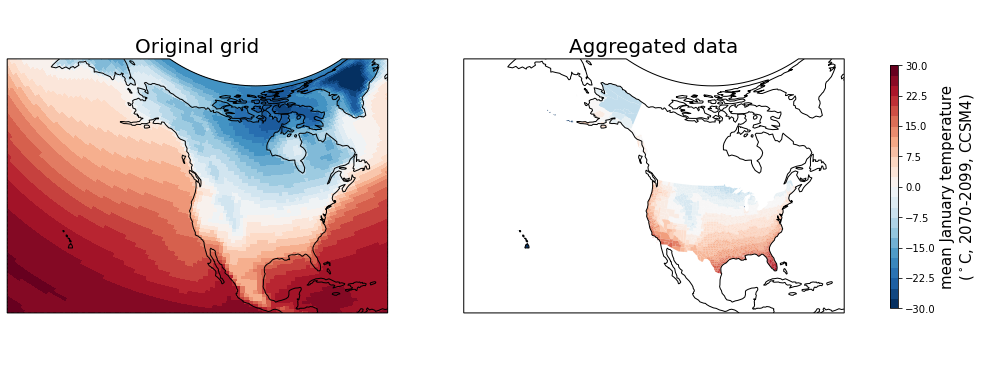

In [12]:
hist_bins = np.arange(273.15-30,273.15+30,2.5)
hist_idxs = np.digitize(gdf.tas,hist_bins)

norm = plt.Normalize(273.15-30, 273.15+30)

proj = ccrs.AlbersEqualArea(central_longitude=-100)

cmap = mpl.cm.RdBu_r
color = cmap(norm(hist_bins))

fig = plt.figure(figsize=(15,5))

ax0 = plt.subplot(1,2,1,projection=proj)
ds.isel(month=0).sortby('lon').tas.plot(transform=ccrs.PlateCarree(),
                                        vmin=273.15-30,vmax=273.15+30,
                                        levels=int(60/2.5)+1,
                                        cmap=mpl.cm.RdBu_r,
                                        add_colorbar=False)
ax0.set_extent([-170,-65,10,80])
ax0.coastlines()
ax0.set_title('Original grid',fontsize=20)


ax1 = plt.subplot(1,2,2,projection=proj)

for hist_digit in np.unique(hist_idxs):
    ax1.add_geometries(gdf.to_crs(proj.proj4_init).iloc[hist_idxs==hist_digit]['geometry'],
                       crs = proj,
                       facecolor=(color[hist_digit]))

ax1.set_extent([-170,-65,10,80])
ax1.coastlines()
ax1.set_title('Aggregated data',fontsize=20)


fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.9, 0, 0.05, 1])
#norm = mpl.colors.Normalize(vmin=-30, vmax=30)
norm = mpl.colors.BoundaryNorm(np.linspace(-30,30,int(60/2.5)+1), cmap.N)
cbar_ax.axis('off')
cb1 = plt.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=cmap),ax=cbar_ax,
                   aspect=30)
cb1.set_label('mean January temperature\n($^\circ$C, 2070-2099, CCSM4)',fontsize=15)

# Step-by-step Run
Here is a step-by-step run, bypassing the wrapper functions to explain what the code is doing behind the scenes. `ds2` in each is just to allow investigating intermediate results.

In [13]:
# Put dataset into the right format (fix lat/lon grid names and remap to -180:180 lon)
ds2 = xa.fix_ds(ds)

In [14]:
# Check to see if latitude/longitude bounds are included in the dataset, and if not, 
# create them from scratch by assuming each pixel extends halfway between coordinates
ds2 = xa.get_bnds(ds2)

In [15]:
# Process weights - if weights are used, they are either regridded to the ds grid 
# (target="ds") or the ds grid is regridded to the weights set (target="weights" - 
# not yet fully implemented). (nothing happens if weights stays None)
ds2 = xa.process_weights(ds2,weights=ds_pop,target="ds")

regridding weights to data grid...
Overwrite existing file: bilinear_720x1440_192x288.nc 
 You can set reuse_weights=True to save computing time.


/Users/kevinschwarzwald/opt/anaconda3/envs/climate1/lib/python3.7/site-packages/xesmf/smm.py:70: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not C_CONTIGUOUS. "


In [16]:
# Create raster polygons (this function actually runs fix_ds, get_bnds, and 
# process_weights). subset_bbox = [gdf] means that only the pixels within the 
# bounding box around the shapefiles (plus a safety distance of a bit more
# than the width of the widest pixel) are processed.
pix_agg = xa.create_raster_polygons(ds,weights=ds_pop,weights_target="ds",
                                 subset_bbox=gdf)

regridding weights to data grid...
Overwrite existing file: bilinear_720x1440_58x91.nc 
 You can set reuse_weights=True to save computing time.


/Users/kevinschwarzwald/opt/anaconda3/envs/climate1/lib/python3.7/site-packages/xesmf/smm.py:70: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not C_CONTIGUOUS. "


In [17]:
# Now calculate the overlap between the raster polygons and the shapefile
# polygons
gdf_out = xa.get_pixel_overlaps(gdf,pix_agg)

In [18]:
# Find subset of ds that matches the subsetted ds (subset_bbox = True above)
# used to create the raster polygons (this function is run in [aggregate] 
# below)
ds2 = xa.subset_find(ds,gdf_out['source_grid'])

adjusting grid... (this may happen because only a subset of pixels were used for aggregation for efficiency - i.e. [subset_bbox=True] in [create_raster_polygons])
grid adjustment successful


In [19]:
# Now, aggregate the original data variables onto the polygons (this contains
# subset_find above)
gdf_out2 = xa.aggregate(ds,gdf_out)

adjusting grid... (this may happen because only a subset of pixels were used for aggregation for efficiency - i.e. [subset_bbox=True] in [create_raster_polygons])
grid adjustment successful
aggregating tas...
all variables aggregated to polygons!
